# Comparing a grid of FSPS spectra to an SDSS spectrum

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fsps
from astroML.plotting import setup_text_plots

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=24)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('font', size=24, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=13)
mpl.rc('axes', labelweight='black')

In [2]:
# start by loading the spectrum
from astropy.io import fits

with fits.open('/Users/ogtelford/Downloads/prospector/spec-2515-54180-0377.fits') as hdus:
    spec = np.array(hdus[1].data)
    info = np.array(hdus[2].data)
    line = np.array(hdus[3].data)

obs = {}
obs['wavelength'] = 10**spec['loglam']
obs['spectrum'] = spec['flux'] * 1e-17
obs['unc'] = spec['ivar']**(-0.5) * 1e-17
obs['sky'] = spec['sky'] * 1e-17


obs['z_sdss'] = info['Z']
gline = line['LINEZ'] > 0.0
obs['sigma_lines'] = [np.median(line['LINESIGMA'][gline])]
obs['z_lines'] = [np.median(line['LINEZ'][gline])]

obs['vdisp_sdss'] = info['VDISP']

obs['deredshifted'] = True
obs['wavelength'] /= (1 + obs['z_sdss'])

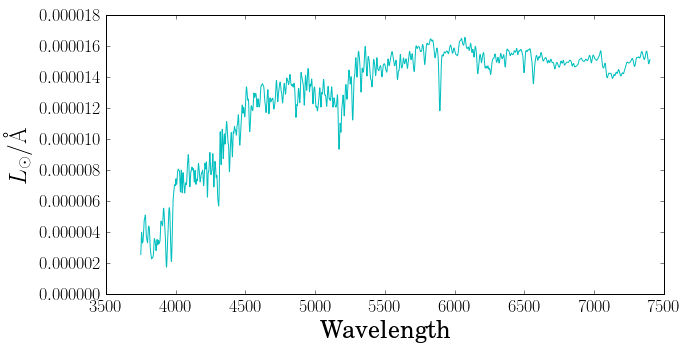

In [3]:
# now generate a model that matches the params fit by prospector -- NB tau is not known!
sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=1,  zmet=21, \
        dust_type=2, dust2=0.255, sf_start=1., tau=1., sigma_smooth=200.)
wave, spec = sp.get_spectrum(tage=12.5, peraa=True) 

fig, ax = plt.subplots(figsize=(10,5))
whmodel = (wave < 7400.) * (wave > 3750.)
ax.plot(wave[whmodel], spec[whmodel], 'c')
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')

In [4]:
# now try to get obs and model at same normalization

whspec = (obs['wavelength'] < 7400.) * (obs['wavelength'] > 3750.)
spec_norm = obs['spectrum'][whspec] * np.sum(whspec) / np.sum(obs['spectrum'][whspec])

model_norm = spec[whmodel] * np.sum(whmodel) / np.sum(spec[whmodel])

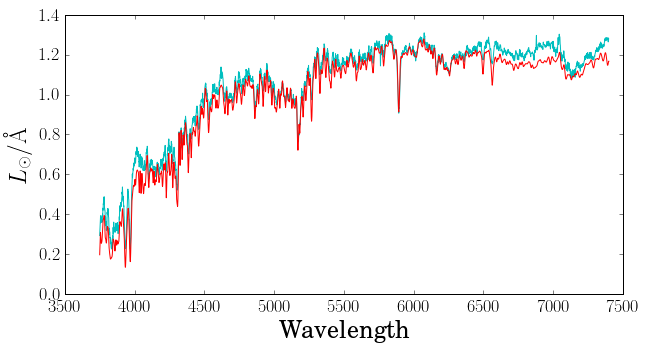

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(obs['wavelength'][whspec], spec_norm, 'c')
ax.plot(wave[whmodel], model_norm, 'r')
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')

#### Well! That worked incredibly well on the first try.

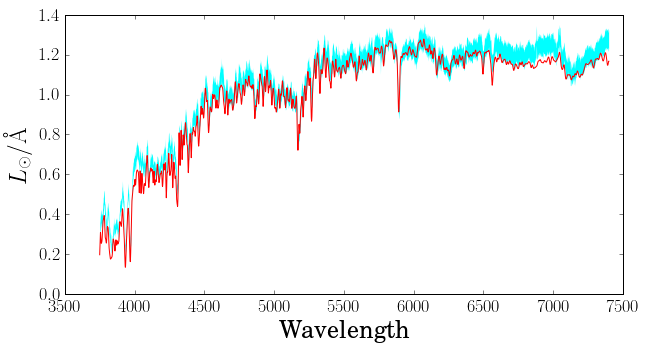

In [6]:
# now make same plot but with normalized uncertainties overplotted

unc_norm = obs['unc'][whspec] * np.sum(whspec) / np.sum(obs['spectrum'][whspec])
unc_norm *= 1

fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan', linewidth=0)
ax.plot(wave[whmodel], model_norm, 'r')
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')

In [7]:
sn = spec_norm / unc_norm
np.median(sn)

49.941879

Well, this is a fairly high S/N spectrum (right?) -- not even this model is consistent within the uncertainties. The uncertainties provide roughly a 68% confidence interval, right? So I should double the width of the "allowable" region to get a 95% confidence interval...

Also, at how many pixels does the model have to match within whatever error threshold we define? Just choose some threshold to start, say 50% to get a kind of "upper limit" on how much the model parameters can vary and still be consistent with observations?

Maybe I should do a calculation of "distance from model to closest point allowed within uncertainties" -- that is, distance = 0 if model lies within error bounds at a given wavelength, and distance = min(dist(min_allowed), dist(max_allowed)) if model lies outside error bounds.

In [8]:
# traditional distance metric
spec_norm_interp = np.interp(wave[whmodel], obs['wavelength'][whspec], spec_norm)
unc_norm_interp = np.interp(wave[whmodel], obs['wavelength'][whspec], unc_norm)

distance = np.sqrt(np.sum((model_norm - spec_norm_interp)**2))
print distance

3.37060832047


In [9]:
# trying a modified distance measure neglecting regions where model overlaps range allowed by uncertainties

def modified_distance(spec_interp, unc_interp, model):
    N = len(model)
    distances_squared = np.zeros(N)
    max_allowed = spec_interp + 2 * unc_interp
    min_allowed = spec_interp - 2 * unc_interp
    
    for ii in range(N):
        if model[ii] > max_allowed[ii]:
            distances_squared[ii] = (model[ii] - max_allowed[ii])**2
        elif model[ii] < min_allowed[ii]:
            distances_squared[ii] = (model[ii] - min_allowed[ii])**2
        else:
            distances_squared[ii] = 0.
    
    return np.sqrt(np.sum(distances_squared)), np.sqrt(distances_squared)

distance, dist_array = modified_distance(spec_norm_interp, unc_norm_interp, model_norm)
print distance

1.63047120315


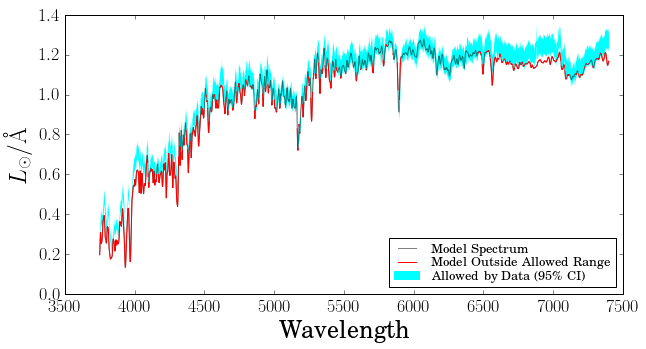

In [10]:
import copy
whbad = dist_array > 0.
bad = copy.deepcopy(model_norm)
bad[~whbad] = np.nan

fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan', 
                linewidth=0, label='Allowed by Data (95\% CI)')
ax.plot(wave[whmodel], model_norm, 'k', alpha=0.5, label='Model Spectrum')
ax.plot(wave[whmodel], bad, 'r', label='Model Outside Allowed Range')
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')

ax.legend(loc=4)
plt.savefig('comp_singleSpec_singleModel.png')

### Now let's build a grid of 125 spectra with parameters close to these

In [11]:
# set up grids in tau, metallicity, and dust
# NB: it's still unclear to me what a reasonable choice of A is...

A = 12.5 # time since the galaxy we're observing started forming stars
sf_begin = 13.7 - A # Gyr after big bang

tau_grid = np.array([0.1, 0.5, 1.0, 1.5, 2.0])
age_grid = A - tau_grid * ( (1. - (A/tau_grid + 1.) * np.exp(-A/tau_grid)) / \
                             (1. - np.exp(-A/tau_grid)) )

log_zsol_grid = [-0.2, -0.1, 0.0, 0.1, 0.2]
zmet_grid = [18, 19, 20, 21, 22]

dust_grid = [0.1, 0.2, 0.25, 0.3, 0.4]

In [15]:
spectra = np.zeros((5, 5, 5, np.sum(whmodel)))

for tt in range(len(tau_grid)):
    for zz in range(len(zmet_grid)):
        for dd in range(len(dust_grid)):
            sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=1,  zmet=zmet_grid[zz], \
                    dust_type=2, dust2=dust_grid[dd], sf_start=1., tau=tau_grid[tt], add_neb_emission=False, \
                    sigma_smooth=250.)
            wave, spec = sp.get_spectrum(tage=12.5, peraa=True)
            spectra[tt, zz, dd, :] = spec[whmodel]

In [16]:
specmatrix = spectra.reshape((125,np.sum(whmodel)))

taus = [tau_grid[0]] * 25 + [tau_grid[1]] * 25 + [tau_grid[2]] * 25 + [tau_grid[3]] * 25 + [tau_grid[4]] * 25

zs = [log_zsol_grid[0]] * 5 + [log_zsol_grid[1]] * 5 + [log_zsol_grid[2]] * 5 + [log_zsol_grid[3]] * 5 \
    + [log_zsol_grid[4]] * 5
zs *= 5

dusts = dust_grid * 25

In [31]:
# normalize the model spectra
norms = np.sum(whmodel) / np.sum(specmatrix, axis=1)
specmatrix_norm = specmatrix * norms[:,np.newaxis]

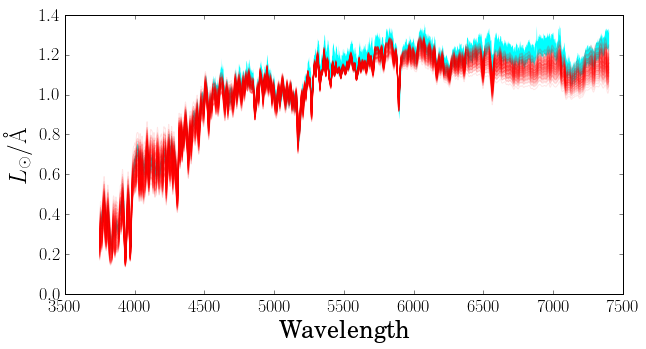

In [38]:
# plot up the first 25 spectra
fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan',
                linewidth=0)
for ii in range(125):
    ax.plot(wave[whmodel], specmatrix_norm[ii], 'r', alpha=0.1)
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')

Very few of the models in this grid can match the red half of the data... would another normalization method help?

In [72]:
dists = np.zeros(np.shape(specmatrix)[0])
euclid_dists = np.zeros(np.shape(specmatrix)[0])
distmatrix = np.zeros(np.shape(specmatrix))

In [73]:
for ii in range(len(dists)):
    dist, distarr = modified_distance(spec_norm_interp, unc_norm_interp, specmatrix_norm[ii])
    dists[ii] = dist
    distmatrix[ii,:] = distarr
    euclid_dists[ii] = np.sqrt(np.sum((specmatrix_norm[ii] - spec_norm_interp)**2))

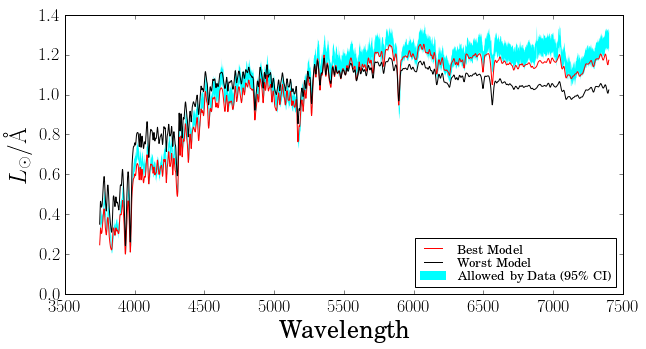

In [70]:
# try plotting best and worst fitting spectra based on this distance metric

wh1 = np.where(dists == np.min(dists))
wh2 = np.where(dists == np.max(dists))

fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan',
                linewidth=0, label='Allowed by Data (95\% CI)')
ax.plot(wave[whmodel], specmatrix_norm[wh1[0][0]], 'r', label='Best Model')
ax.plot(wave[whmodel], specmatrix_norm[wh2[0][0]], 'k', label='Worst Model')
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')
ax.legend(loc=4)

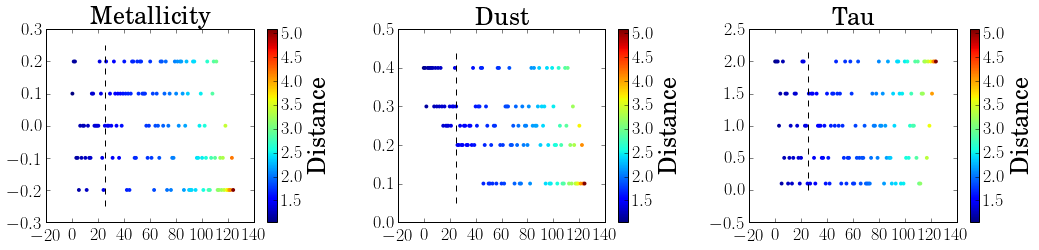

In [84]:
# try to visualize which parameters produce spectra that are most consistent with the data
test = np.argsort(dists)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].set_title('Metallicity')
ax[0].plot([25,25], [-0.25,0.25], 'k--')
hm = ax[0].scatter(np.arange(125), np.array(zs)[test], c=dists[test], s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[0])

ax[1].set_title('Dust')
ax[1].plot([25,25], [0.05,0.45], 'k--')
hm = ax[1].scatter(np.arange(125), np.array(dusts)[test], c=dists[test], s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[1])

ax[2].set_title('Tau')
ax[2].plot([25,25], [0.,2.2], 'k--')
hm = ax[2].scatter(np.arange(125), np.array(taus)[test], c=dists[test], s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[2])

plt.tight_layout()

In [82]:
zs[wh1[0][0]], taus[wh1[0][0]], dusts[wh1[0][0]]

(0.1, 2.0, 0.4)

In [98]:
# ok, let's look at this another way -- what range of params give you >50% of points consistent w/ data?
consistent = np.sum(distmatrix==0, axis=1) # count up number of consistent points in each spectrum
frac_consistent = consistent.astype(float) / np.shape(distmatrix)[1]

In [101]:
np.where(frac_consistent == np.max(frac_consistent)) # NOT the same spectrum that gives min distance!

(array([22]),)

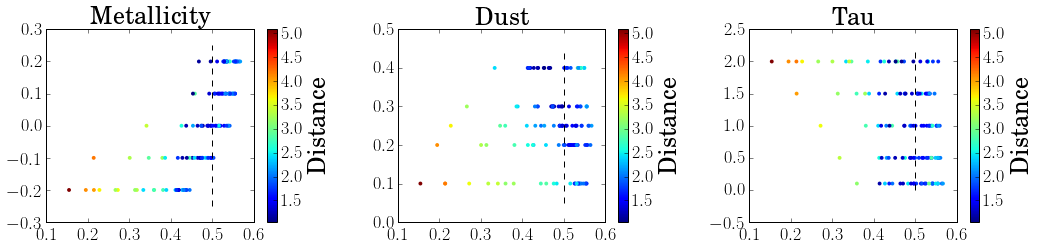

In [105]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].set_title('Metallicity')
ax[0].plot([0.5,0.5], [-0.25,0.25], 'k--')
hm = ax[0].scatter(frac_consistent, np.array(zs), c=dists, s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[0])

ax[1].set_title('Dust')
ax[1].plot([0.5,0.5], [0.05,0.45], 'k--')
hm = ax[1].scatter(frac_consistent, np.array(dusts), c=dists, s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[1])

ax[2].set_title('Tau')
ax[2].plot([0.5,0.5], [0.,2.2], 'k--')
hm = ax[2].scatter(frac_consistent, np.array(taus), c=dists, s=15, lw=0)
plt.colorbar(hm, label=r'Distance', ax=ax[2])

plt.tight_layout()

## Takeaways so far

Setting thresholds for (1) "modified distance" from observed spectrum and (2) fraction of points "consistent" with observed spectrum constrain different parameters -- the former only restricts the range of dust2, and the latter only restricts the range of metallicity in this example. 
  * maybe constructing some sort of hybrid measure of similarity is the solution?
  * possible weighting of certain spectral regions? e.g., really want to fit the depth of the Ca lines?
  * best way to handle normalization? could my current method be affecting the fraction of consistent points?
  
This all seems very specific to the particular observed spectrum. To make broad statements about the "allowed range" of parameters, will need to do this for many types of galaxies at many different S/N levels. Is there a quick way to make a "first pass" to choose the region of parameter space on which to focus a model grid?

### Digression: Why are fraction of consistent points and modified distance so different?

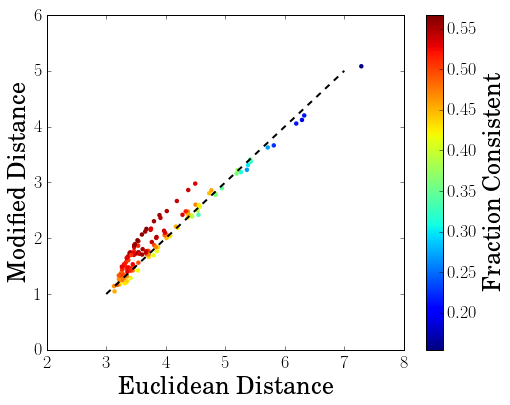

In [107]:
# how do euclidean distances and modified distances compare?
fig, ax = plt.subplots(figsize=(8,6))
hm = ax.scatter(euclid_dists, dists, c=frac_consistent, linewidth=0)
ax.plot([3,7], [1,5], 'k--', linewidth=2)
plt.colorbar(hm, label='Fraction Consistent', ax=ax)
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Modified Distance')

In [120]:
hmm1 = frac_consistent > 0.5

(3750, 4500)

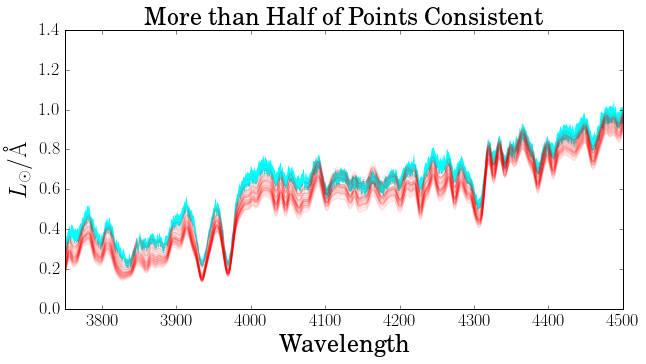

In [150]:
# look at the spectra that have high modified distances relative to euclidean
fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan',
                linewidth=0)
for ii in range(np.sum(hmm1)):
    ax.plot(wave[whmodel], specmatrix_norm[hmm1][ii], 'r', alpha=0.1)
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')
ax.set_title('More than Half of Points Consistent')
ax.set_xlim([3750,4500])

In [122]:
hmm2 = frac_consistent < 0.5

(3750, 4500)

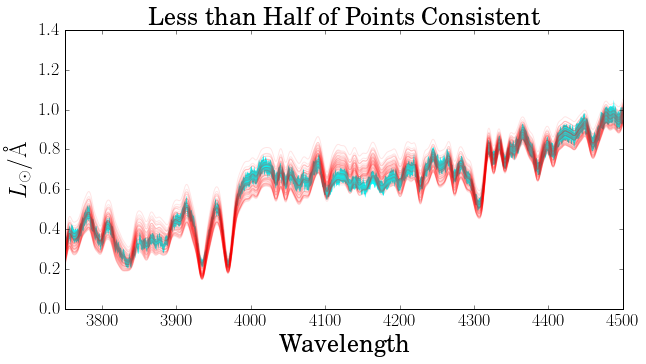

In [151]:
# look at the spectra that have high modified distances relative to euclidean
fig, ax = plt.subplots(figsize=(10,5))
ax.fill_between(obs['wavelength'][whspec], spec_norm + 2*unc_norm, spec_norm - 2*unc_norm, facecolor='cyan',
                linewidth=0)
for ii in range(np.sum(hmm2)):
    ax.plot(wave[whmodel], specmatrix_norm[hmm2][ii], 'r', alpha=0.1)
ax.set_xlabel('Wavelength')
ax.set_ylabel(r'$L_\odot/\mathrm{\AA}$')
ax.set_title('Less than Half of Points Consistent')
ax.set_xlim([3750,4500])

Hmm... look at fraction of consistent points as a function of wavelength somehow? Split into these two groups of spectra? The difference between the groups is not immediately obvious...

plot of distance vs. wavelength color coded by fraction consistent?

In [133]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=np.min(frac_consistent), vmax=np.max(frac_consistent))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

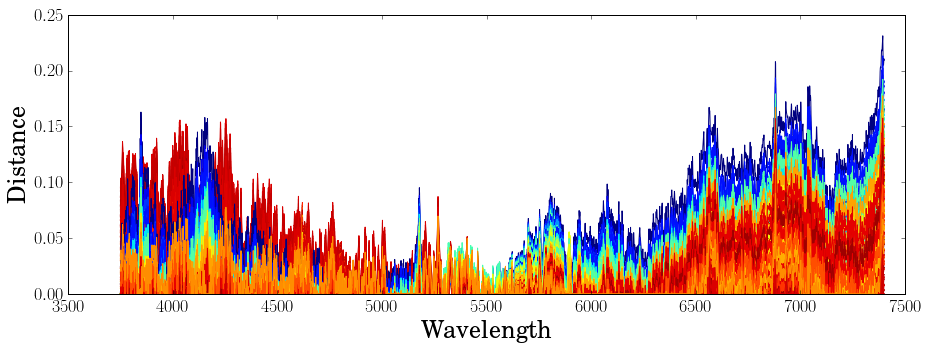

In [147]:
# all models -- distance from data vs. wavelength, cc by frac_consistent
fig, ax = plt.subplots(figsize=(15,5))
for ii in range(np.shape(specmatrix_norm)[0]):
    colorVal = scalarMap.to_rgba(frac_consistent[ii])
    ax.plot(wave[whmodel], distmatrix[ii], color=colorVal)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Distance')

So, don't know how to attach a colorbar to this right now... red = higher fraction of points consistent. It's not clear from this figure where exactly that's happening (the central wavelengths I suppose?) but it is pretty clear that the red lines deviate pretty badly at the blue end. 

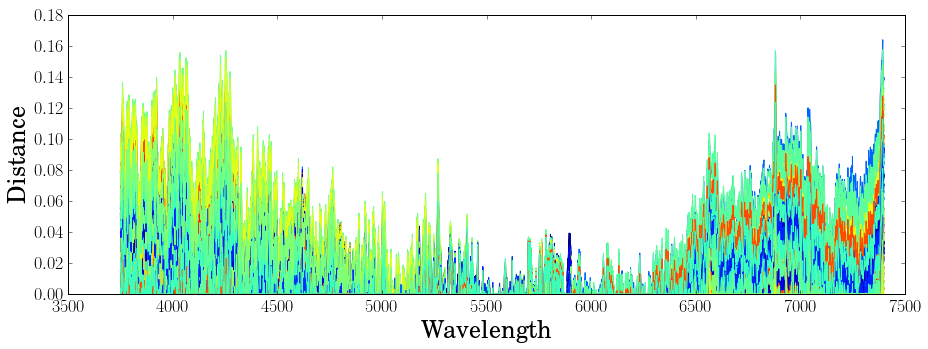

In [149]:
# same thing, but for the >50% consistent spectra only

cNorm  = colors.Normalize(vmin=np.min(frac_consistent[hmm1]), vmax=np.max(frac_consistent[hmm1]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(figsize=(15,5))
for ii in range(np.sum(hmm1)):

    colorVal = scalarMap.to_rgba(frac_consistent[hmm1][ii])
    ax.plot(wave[whmodel], distmatrix[hmm1][ii], color=colorVal)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Distance')

Hmm... ok, this is making me think that requiring some threshold in "fraction of points consistent" is arbitrary and not that useful... 